In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm

# Inspect single training

In [ ]:
# train_folder = Path(
#     r"C:\Users\inserm\Documents\histo_sign\trainings\2024-03-12_15-30-06"
# )  # 4 signatures ppaint
train_folder = Path(
    r"C:\Users\inserm\Documents\histo_sign\trainings\signatures\2024-03-12_15-41-54"
)  # All signatures
# train_folder = Path(r"C:\Users\inserm\Documents\histo_sign\trainings\2024-03-12_15-50-27")  # Selec signatures
# train_folder = Path(r"C:\Users\inserm\Documents\histo_sign\trainings\2024-03-12_15-54-02")  # Classic Basal
# train_folder = Path(r"C:\Users\inserm\Documents\histo_sign\trainings\2024-03-12_15-56-31")  # Stroma Activ/Ina
# train_folder = Path(r"C:\Users\inserm\Documents\histo_sign\trainings\2024-03-12_16-01-52")  # Hwang only

In [ ]:
# Open the txt file a dictionnary
with open(train_folder / "params.txt", "r") as file:
    params = file.readlines()
    params = eval(params[0])
params

In [ ]:
corr_df = pd.DataFrame()
for split in train_folder.glob("split_*"):
    split = split.name
    with open(train_folder / split / "val_corrs.npy", "rb") as file:
        corrs = np.load(file, allow_pickle=True)
        corrs = corrs.tolist()
        corrs = pd.DataFrame(corrs, index=[0])
        corrs["split"] = split
        corr_df = pd.concat([corr_df, corrs], axis=0)

corr_df.index = corr_df["split"]
corr_df = corr_df.drop(columns="split")
corr_df

In [ ]:
# Plot as a heatmap
sns.heatmap(corr_df, center=0)

In [ ]:
avg_corr = corr_df.mean(axis=0)
avg_corr = avg_corr.sort_values(ascending=False)

nb_top = 15

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=avg_corr[:nb_top], y=avg_corr.index[:nb_top], ax=ax)
ax.set_title("Average correlation of the top 10 signatures")
ax.set_title("Top 10 average correlation of the signatures")
ax.set_xlabel("Average correlation")
ax.set_ylabel("Feature")
plt.show()

In [ ]:
split_nb = 4
split_df = corr_df.loc[f"split_{split_nb}"]
split_df = split_df.sort_values(ascending=False)

nb_top = 15

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=split_df[:nb_top], y=split_df.index[:nb_top], ax=ax)
ax.set_title(f"Correlation of the top {nb_top} signatures on split {split_nb}")
ax.set_xlabel("Average correlation")
ax.set_ylabel("Feature")
plt.show()

In [ ]:
# Find the best split
best_split = corr_df.idxmax(axis=0).T
best_split = best_split.reset_index()
best_split.rename(columns={"index": "signature", 0: "split"}, inplace=True)
best_split["correlation"] = corr_df.max(axis=0).values
best_split.sort_values(by="correlation", ascending=False, inplace=True)
best_split.reset_index(drop=True, inplace=True)

n_top = 30
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(
    x=best_split["correlation"][:n_top],
    y=best_split["signature"][:n_top],
    ax=ax,
    hue=best_split["split"][:n_top],
)
ax.set_title(f"Top {n_top} signatures with the best correlation")
ax.set_xlabel("Correlation")
ax.set_ylabel("Feature")
plt.show()

In [ ]:
best_split.to_csv(r"C:\Users\inserm\Documents\histo_sign\dataset\best_split.csv", index=False)

In [ ]:
# new_col_to_pred = list(best_split[:n_top].signature.values)
# # new_col_to_pred = []
# new_col_to_pred += list(corr_df.filter(like="Hwang").columns.values)
# new_col_to_pred += ["Classic", "StromaActiv", "Basal", "StromaInactive"]
# new_col_to_pred = list(set(new_col_to_pred))
# np.savetxt(
#     Path(r"C:\Users\inserm\Documents\histo_sign\dataset\new_col_names.txt"),
#     new_col_to_pred,
#     fmt="%s",
#     encoding="utf-8",
# )

In [ ]:
new_col_to_pred = np.loadtxt(
    Path(r"C:\Users\inserm\Documents\histo_sign\dataset\new_col_names.txt"),
    dtype=str,
    encoding="utf-8",
)
new_pred = best_split[best_split.signature.isin(new_col_to_pred)]
# plot
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=new_pred["correlation"], y=new_pred["signature"], ax=ax)
ax.set_title("Correlation on the prediction signature list")
ax.set_xlabel("Correlation")
ax.set_ylabel("Feature")
plt.show()

# All signatures training

In [ ]:
# folder_path = Path(r"C:\Users\inserm\Documents\histo_sign\trainings\single_signatures\2024-03-15_15-44-10") # selected signatures
# folder_path = Path(
#     r"C:\Users\inserm\Documents\histo_sign\trainings\single_signatures\2024-03-15_16-00-21"
# )  # all signatures
folder_path = Path(
    r"C:\Users\inserm\Documents\histo_sign\trainings\single_signatures\2024-03-27_17-00-26"
)  # all signatures

In [ ]:
sign_path = list(folder_path.glob("*"))
sign_path = [x for x in sign_path if x.is_dir()]
sign_name = [x.name for x in sign_path]
recap_df = pd.DataFrame({"signature": sign_name, "path": sign_path})

In [ ]:
row = recap_df.iloc[0]
val_corr = np.load(row.path / f"split_{0}" / "val_corrs.npy", allow_pickle=True)
val_corr = np.load(row.path / f"split_{0}" / "train_corrs.npy", allow_pickle=True)
val_corr

In [ ]:
def get_sgn(row):
    val_corr_sgn = {}
    train_corr_sgn = {}
    corr_sgn = {}
    for k in range(0, 5):
        val_corr = np.load(row.path / f"split_{k}" / "val_corrs.npy", allow_pickle=True)
        train_corr = np.load(row.path / f"split_{k}" / "train_corrs.npy", allow_pickle=True)
        val_corr = val_corr.tolist()
        train_corr = train_corr.tolist()
        # print(val_corr.keys())
        if row.signature in val_corr:
            val_corr = val_corr[row.signature]
            train_corr = train_corr[row.signature]
        elif row.signature == "CCCA_MetaProg_MP16.MES.glioma":
            val_corr = val_corr["CCCA_MetaProg_MP16.MES.glioma."]
            train_corr = train_corr["CCCA_MetaProg_MP16.MES.glioma."]
        elif row.signature == "CCCA_MetaProg_MP17.Interferon.MHC.II.I":
            val_corr = val_corr["CCCA_MetaProg_MP17.Interferon.MHC.II.I."]
            train_corr = train_corr["CCCA_MetaProg_MP17.Interferon.MHC.II.I."]
        elif row.signature == "CCCA_MetaProg_MP18.Interferon.MHC.II.II":
            val_corr = val_corr["CCCA_MetaProg_MP18.Interferon.MHC.II.II."]
            train_corr = train_corr["CCCA_MetaProg_MP18.Interferon.MHC.II.II."]
        elif row.signature == "CCCA_MetaProg_MP7.Stress.in.vitro":
            val_corr = val_corr["CCCA_MetaProg_MP7.Stress.in.vitro."]
            train_corr = train_corr["CCCA_MetaProg_MP7.Stress.in.vitro."]
        else:
            raise ValueError(f"{row.signature} not found in {val_corr.keys()}")
        val_corr_sgn[f"split_{k}"] = val_corr
        train_corr_sgn[f"split_{k}"] = train_corr
        corr_sgn[f"train_split_{k}"] = train_corr
        corr_sgn[f"val_split_{k}"] = val_corr
    # return val_corr_sgn, train_corr_sgn
    return corr_sgn


res = recap_df.apply(get_sgn, axis=1, result_type="expand")
recap_df = pd.concat([recap_df, res], axis=1)
recap_df

In [ ]:
# recap_df["mean_corr"] = recap_df.filter(like="split_").mean(axis=1)
# recap_df["best_split"] = recap_df.filter(like="split_").idxmax(axis=1)
# recap_df["best_corr"] = recap_df.filter(like="split_").max(axis=1)
# recap_df["model_path"] = recap_df.apply(lambda x: x.path / x.best_split / "model.pth", axis=1)
# recap_df.sort_values(by="best_corr", ascending=False, inplace=True)
# recap_df.reset_index(drop=True, inplace=True)
recap_df["mean_corr_train"] = recap_df.filter(like="train_split_").mean(axis=1)
recap_df["best_split_train"] = recap_df.filter(like="train_split_").idxmax(axis=1)
recap_df["best_corr_train"] = recap_df.filter(like="train_split_").max(axis=1)
recap_df["mean_corr_val"] = recap_df.filter(like="val_split_").mean(axis=1)
recap_df["best_split_val"] = recap_df.filter(like="val_split_").idxmax(axis=1)
recap_df["best_corr_val"] = recap_df.filter(like="val_split_").max(axis=1)
recap_df["model_path"] = recap_df.apply(lambda x: x.path / x.best_split_val / "model.pth", axis=1)
recap_df.sort_values(by="best_corr_val", ascending=False, inplace=True)
recap_df.reset_index(drop=True, inplace=True)
recap_df

In [ ]:
selected_sign = np.loadtxt(
    r"C:\Users\inserm\Documents\histo_sign\dataset\selected_col_names.txt", dtype=str, encoding="utf-8"
)
recap_df["selected"] = recap_df.signature.isin(selected_sign)

In [ ]:
recap_df

In [ ]:
# plot
n_top = 30
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(
    x=recap_df["best_corr_val"][:n_top],
    y=recap_df["signature"][:n_top],
    ax=ax,
    # hue=recap_df["selected"][:n_top],
    color="blue",
    label="Validation",
)
sns.barplot(
    x=recap_df["best_corr_train"][:n_top],
    y=recap_df["signature"][:n_top],
    ax=ax,
    # hue=recap_df["selected"][:n_top],
    color="red",
    alpha=0.3,
    label="Train",
)
ax.set_title("Best validation correlation across splits for each signature")
ax.set_xlabel("Correlation")
ax.set_ylabel("Signature")
plt.show()

In [ ]:
valid_model = recap_df[:10]
valid_sign = valid_model.signature.values
valid_sign = list(set(valid_sign).union(set(["Classic", "StromaActiv", "Basal", "StromaInactive"])))
valid_model = recap_df[recap_df.signature.isin(valid_sign)]

res = valid_model[["signature", "model_path"]]
res_dict = res.set_index("signature").T.to_dict("list")
for k, v in res_dict.items():
    res_dict[k] = v[0].as_posix()
print(f"Keeping {len(res_dict)} models")
# np.save(r"C:\Users\inserm\Documents\histo_sign\dataset\best_model_path.npy", res_dict)
sns.barplot(data=valid_model, x="best_corr_val", y="signature")
plt.title("Best validation correlation across splits for each signature")
plt.xlabel("Correlation")
plt.ylabel("Signature")
plt.show()

In [ ]:
recap_df[recap_df.signature.str.contains("Basal")]
recap_df[recap_df.signature.str.contains("Classic")]
recap_df[recap_df.signature.str.contains("Stroma")]

In [ ]:
classic_basal_sign = recap_df[
    recap_df.signature.str.contains("Basal") | recap_df.signature.str.contains("Classic")
]
classic_basal_sign = classic_basal_sign.signature.values
classic_basal_sign = list(set(classic_basal_sign).union(set(["Classic", "Basal"])))
classic_basal_sign = recap_df[recap_df.signature.isin(classic_basal_sign)]

res = classic_basal_sign[["signature", "model_path"]]
res_dict = res.set_index("signature").T.to_dict("list")
for k, v in res_dict.items():
    res_dict[k] = v[0].as_posix()
print(f"Keeping {len(res_dict)} models")
# np.save(r"C:\Users\inserm\Documents\histo_sign\dataset\classic_basal_model_path.npy", res_dict)

sns.barplot(data=classic_basal_sign, x="best_corr_val", y="signature")
plt.title("Best validation correlation across splits for basal and classic signatures")
plt.xlabel("Correlation")
plt.ylabel("Signature")
plt.show()

In [ ]:
hwang_df = recap_df[recap_df.signature.str.contains("Hwang")]
hwang_sign = hwang_df.signature.values
hwang_sign = list(set(hwang_sign).union(set(["Classic", "StromaActiv", "Basal", "StromaInactive"])))
hwang_df = recap_df[recap_df.signature.isin(hwang_sign)]

res = hwang_df[["signature", "model_path"]]
res_dict = res.set_index("signature").T.to_dict("list")
for k, v in res_dict.items():
    res_dict[k] = v[0].as_posix()

print(f"Keeping {len(res_dict)} models")
# np.save(r"C:\Users\inserm\Documents\histo_sign\dataset\hwang_model_path.npy", res_dict)
sns.barplot(data=hwang_df, x="best_corr_val", y="signature")
plt.title("Best validation correlation across splits for Hwang signatures")
plt.xlabel("Correlation")
plt.ylabel("Signature")
plt.show()

In [ ]:
all_sign = recap_df.signature.values
all_sign = list(set(all_sign).union(set(["Classic", "StromaActiv", "Basal", "StromaInactive"])))
all_sign = recap_df[recap_df.signature.isin(all_sign)]

res = all_sign[["signature", "model_path"]]
res_dict = res.set_index("signature").T.to_dict("list")
for k, v in res_dict.items():
    res_dict[k] = v[0].as_posix()
print(f"Keeping {len(res_dict)} models")
np.save(r"C:\Users\inserm\Documents\histo_sign\dataset\all_model_path.npy", res_dict)
sns.barplot(data=all_sign, x="best_corr_val", y="signature")
plt.title("Best validation correlation across splits for all signatures")
plt.xlabel("Correlation")
plt.ylabel("Signature")
plt.show()

# Explore grid search

In [2]:
def get_sgn(row, run_params=None):
    corr_sgn = {}
    for k in range(0, 5):
        val_corr = np.load(row[f"path_{run_params}"] / f"split_{k}" / "val_corrs.npy", allow_pickle=True)
        train_corr = np.load(row[f"path_{run_params}"] / f"split_{k}" / "train_corrs.npy", allow_pickle=True)
        val_corr = val_corr.tolist()
        train_corr = train_corr.tolist()
        # print(val_corr.keys())
        if row.signature in val_corr:
            val_corr = val_corr[row.signature]
            train_corr = train_corr[row.signature]
        elif row.signature == "CCCA_MetaProg_MP16.MES.glioma":
            val_corr = val_corr["CCCA_MetaProg_MP16.MES.glioma."]
            train_corr = train_corr["CCCA_MetaProg_MP16.MES.glioma."]
        elif row.signature == "CCCA_MetaProg_MP17.Interferon.MHC.II.I":
            val_corr = val_corr["CCCA_MetaProg_MP17.Interferon.MHC.II.I."]
            train_corr = train_corr["CCCA_MetaProg_MP17.Interferon.MHC.II.I."]
        elif row.signature == "CCCA_MetaProg_MP18.Interferon.MHC.II.II":
            val_corr = val_corr["CCCA_MetaProg_MP18.Interferon.MHC.II.II."]
            train_corr = train_corr["CCCA_MetaProg_MP18.Interferon.MHC.II.II."]
        elif row.signature == "CCCA_MetaProg_MP7.Stress.in.vitro":
            val_corr = val_corr["CCCA_MetaProg_MP7.Stress.in.vitro."]
            train_corr = train_corr["CCCA_MetaProg_MP7.Stress.in.vitro."]
        else:
            raise ValueError(f"{row.signature} not found in {val_corr.keys()}")

        if run_params is None:
            _run_params = ""
        else:
            _run_params = f"{run_params}_"
        corr_sgn[f"{_run_params}train_split_{k}"] = train_corr
        corr_sgn[f"{_run_params}val_split_{k}"] = val_corr
    return corr_sgn

In [3]:
folder_path = Path(r"C:\Users\inserm\Documents\histo_sign\trainings\grid_search")

In [4]:
runs = list(folder_path.glob("*"))
recap_df = pd.DataFrame(columns=["signature"])
for run in tqdm(runs):
    sign_path = list(run.glob("*/*"))
    sign_path = [x for x in sign_path if x.is_dir()]
    sign_name = [x.name for x in sign_path]
    run_df = pd.DataFrame({"signature": sign_name, f"path_{run.name}": sign_path})
    try:
        get_sgn_run = lambda x: get_sgn(x, run.name)
        res = run_df.apply(get_sgn_run, axis=1, result_type="expand")
        run_df = pd.concat([run_df, res], axis=1)
    except FileNotFoundError as e:
        print(f"Run {run} not complete")
        print(e)
        break
    # recap_df = pd.concat([recap_df, run_df], axis=1)
    recap_df = pd.merge(recap_df, run_df, on="signature", how="outer")

100%|██████████| 20/20 [01:55<00:00,  5.78s/it]


In [5]:
recap_df["mean_corr_train"] = recap_df.filter(like="train_split_").mean(axis=1)
recap_df["best_split_train"] = recap_df.filter(like="train_split_").idxmax(axis=1)
recap_df["best_corr_train"] = recap_df.filter(like="train_split_").max(axis=1)
recap_df["mean_corr_val"] = recap_df.filter(like="val_split_").mean(axis=1)
recap_df["best_split_val"] = recap_df.filter(like="val_split_").idxmax(axis=1)
recap_df["best_corr_val"] = recap_df.filter(like="val_split_").max(axis=1)
recap_df["corresponding_train_corr"] = recap_df.apply(
    lambda x: x[f"{x.best_split_val.replace('val', 'train')}"], axis=1
)


def get_model_path(row):
    key, split = row.best_split_val.split("_val_")
    key = f"path_{key}"
    return row[key] / split / "model.pth"


recap_df["model_path"] = recap_df.apply(get_model_path, axis=1)
recap_df.sort_values(by="best_corr_val", ascending=False, inplace=True)
recap_df.reset_index(drop=True, inplace=True)
recap_df.to_csv(r"C:\Users\inserm\Documents\histo_sign\src\signatures\recap_df.tsv", sep="\t", index=False)
recap_df

,signature,path_lr_0.0001_wd_0,lr_0.0001_wd_0_train_split_0,lr_0.0001_wd_0_val_split_0,lr_0.0001_wd_0_train_split_1,lr_0.0001_wd_0_val_split_1,lr_0.0001_wd_0_train_split_2,lr_0.0001_wd_0_val_split_2,lr_0.0001_wd_0_train_split_3,lr_0.0001_wd_0_val_split_3,...,lr_0.1_wd_0.1_train_split_4,lr_0.1_wd_0.1_val_split_4,mean_corr_train,best_split_train,best_corr_train,mean_corr_val,best_split_val,best_corr_val,corresponding_train_corr,model_path
0,IMMU_MCPcounter_B.lineage,C:\Users\inserm\Documents\histo_sign\trainings...,0.936871,0.946789,0.953353,0.689067,0.925151,-0.083036,0.942192,-0.025480,...,0.139854,NaN,0.665210,lr_0.001_wd_0.0001_train_split_3,0.992053,0.310942,lr_0.01_wd_0.001_val_split_0,0.967139,0.961568,C:\Users\inserm\Documents\histo_sign\trainings...
1,CCCA_MetaProg_MP38.Glutathione,C:\Users\inserm\Documents\histo_sign\trainings...,0.957160,-0.175005,0.959770,-0.058061,0.908095,-0.061429,0.983049,-0.027498,...,NaN,NaN,0.622486,lr_0.001_wd_0_train_split_0,0.986179,0.040626,lr_0.1_wd_0.001_val_split_4,0.862406,0.009335,C:\Users\inserm\Documents\histo_sign\trainings...
2,PDAC_Bailey16_ADEX,C:\Users\inserm\Documents\histo_sign\trainings...,0.994372,-0.080201,0.986138,0.229202,0.991917,0.851660,0.977751,0.227084,...,NaN,NaN,0.732754,lr_0.01_wd_0_train_split_0,0.998177,0.172154,lr_0.001_wd_0_val_split_2,0.856044,0.989867,C:\Users\inserm\Documents\histo_sign\trainings...
3,CAF_Turley20_hCAF2il6lif,C:\Users\inserm\Documents\histo_sign\trainings...,0.981903,-0.102745,0.983221,-0.029673,0.994131,0.185215,0.963774,0.008585,...,NaN,NaN,0.601946,lr_0.001_wd_0_train_split_2,0.995580,0.046073,lr_0.01_wd_0_val_split_0,0.826194,-0.665702,C:\Users\inserm\Documents\histo_sign\trainings...
4,StromaActiv,C:\Users\inserm\Documents\histo_sign\trainings...,0.869667,0.648030,0.887577,0.441892,0.890330,0.576735,0.886904,0.551065,...,0.163340,0.011164,0.786545,lr_0.01_wd_0_train_split_4,0.999169,0.480799,lr_0.01_wd_0.001_val_split_0,0.803093,0.965182,C:\Users\inserm\Documents\histo_sign\trainings...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,CAF_FMG20_Normal.Fibroblast,C:\Users\inserm\Documents\histo_sign\trainings...,0.893001,0.032471,0.928974,-0.077522,0.884819,-0.014969,0.973707,0.002944,...,NaN,NaN,0.675818,lr_0.001_wd_0_train_split_3,0.997542,-0.010449,lr_0.001_wd_0_val_split_3,0.226293,0.997542,C:\Users\inserm\Documents\histo_sign\trainings...
115,CCCA_MetaProg_MP3.Cell.Cylce.HMG.rich,C:\Users\inserm\Documents\histo_sign\trainings...,0.965717,-0.036167,0.974860,-0.091402,0.985174,-0.035462,0.959482,-0.087475,...,0.027494,0.013111,0.637503,lr_0.001_wd_0_train_split_4,0.994325,-0.063133,lr_0.0001_wd_0.1_val_split_3,0.206704,0.274529,C:\Users\inserm\Documents\histo_sign\trainings...
116,IMMU_Tcellatlas_CD4_c1_Treg,C:\Users\inserm\Documents\histo_sign\trainings...,0.756424,-0.166731,0.691292,0.033156,0.691369,0.088393,0.707830,-0.008501,...,NaN,NaN,0.590760,lr_0.001_wd_0_train_split_1,0.981674,-0.029785,lr_0.01_wd_0.001_val_split_2,0.199619,0.207723,C:\Users\inserm\Documents\histo_sign\trainings...
117,CCCA_MetaProg_MP23.Secreted.II,C:\Users\inserm\Documents\histo_sign\trainings...,0.974626,-0.133478,0.974468,-0.106450,0.959618,-0.059313,0.589045,-0.125145,...,NaN,NaN,0.627447,lr_0.001_wd_0.0001_train_split_2,0.987864,-0.092317,lr_0.0001_wd_0.01_val_split_2,0.182601,0.400115,C:\Users\inserm\Documents\histo_sign\trainings...


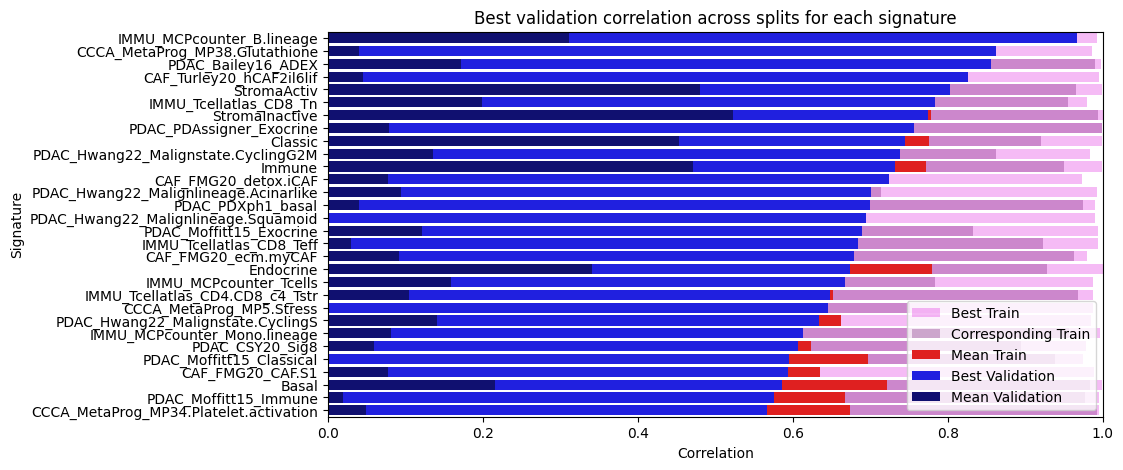

In [6]:
# plot
n_top = 30
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(
    x=recap_df["best_corr_train"][:n_top],
    y=recap_df["signature"][:n_top],
    ax=ax,
    color="magenta",
    alpha=0.3,
    label="Best Train",
)
sns.barplot(
    x=recap_df["corresponding_train_corr"][:n_top],
    y=recap_df["signature"][:n_top],
    ax=ax,
    color="purple",
    alpha=0.3,
    label="Corresponding Train",
)
sns.barplot(
    x=recap_df["mean_corr_train"][:n_top],
    y=recap_df["signature"][:n_top],
    ax=ax,
    color="red",
    label="Mean Train",
)
sns.barplot(
    x=recap_df["best_corr_val"][:n_top],
    y=recap_df["signature"][:n_top],
    ax=ax,
    color="blue",
    alpha=1,
    label="Best Validation",
)
sns.barplot(
    x=recap_df["mean_corr_val"][:n_top],
    y=recap_df["signature"][:n_top],
    ax=ax,
    color="navy",
    alpha=1,
    label="Mean Validation",
)
ax.set_title("Best validation correlation across splits for each signature")
ax.set_xlabel("Correlation")
ax.set_ylabel("Signature")
plt.xlim(0, 1)
plt.show()

Keeping 11 models


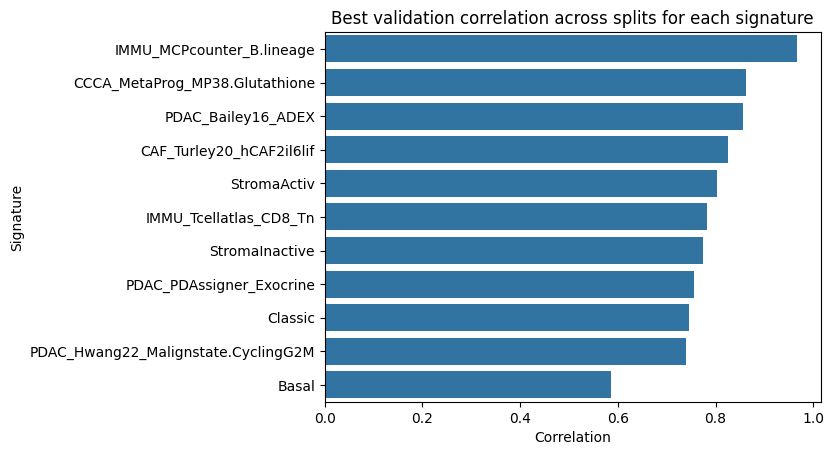

In [7]:
valid_model = recap_df[:10]
valid_sign = valid_model.signature.values
valid_sign = list(set(valid_sign).union(set(["Classic", "StromaActiv", "Basal", "StromaInactive"])))
valid_model = recap_df[recap_df.signature.isin(valid_sign)]

res = valid_model[["signature", "model_path"]]
res_dict = res.set_index("signature").T.to_dict("list")
for k, v in res_dict.items():
    res_dict[k] = v[0].as_posix()
print(f"Keeping {len(res_dict)} models")
np.save(r"C:\Users\inserm\Documents\histo_sign\dataset\best_model_path.npy", res_dict)
sns.barplot(data=valid_model, x="best_corr_val", y="signature")
plt.title("Best validation correlation across splits for each signature")
plt.xlabel("Correlation")
plt.ylabel("Signature")
plt.show()

Keeping 10 models


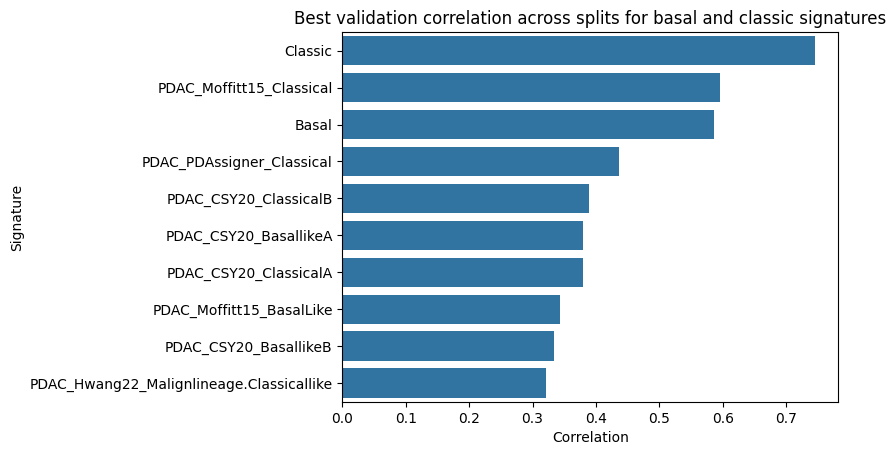

In [8]:
classic_basal_sign = recap_df[
    recap_df.signature.str.contains("Basal") | recap_df.signature.str.contains("Classic")
]
classic_basal_sign = classic_basal_sign.signature.values
classic_basal_sign = list(set(classic_basal_sign).union(set(["Classic", "Basal"])))
classic_basal_sign = recap_df[recap_df.signature.isin(classic_basal_sign)]

res = classic_basal_sign[["signature", "model_path"]]
res_dict = res.set_index("signature").T.to_dict("list")
for k, v in res_dict.items():
    res_dict[k] = v[0].as_posix()
print(f"Keeping {len(res_dict)} models")
np.save(r"C:\Users\inserm\Documents\histo_sign\dataset\classic_basal_model_path.npy", res_dict)

sns.barplot(data=classic_basal_sign, x="best_corr_val", y="signature")
plt.title("Best validation correlation across splits for basal and classic signatures")
plt.xlabel("Correlation")
plt.ylabel("Signature")
plt.show()

Keeping 18 models


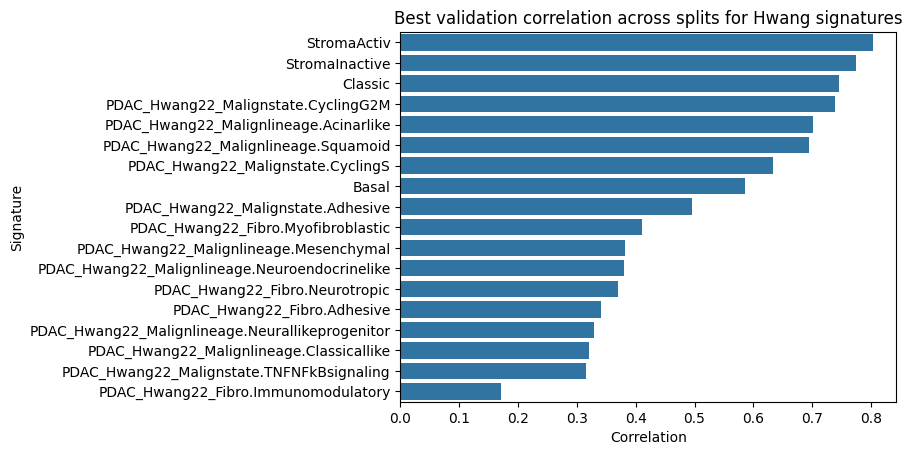

In [9]:
hwang_df = recap_df[recap_df.signature.str.contains("Hwang")]
hwang_sign = hwang_df.signature.values
hwang_sign = list(set(hwang_sign).union(set(["Classic", "StromaActiv", "Basal", "StromaInactive"])))
hwang_df = recap_df[recap_df.signature.isin(hwang_sign)]

res = hwang_df[["signature", "model_path"]]
res_dict = res.set_index("signature").T.to_dict("list")
for k, v in res_dict.items():
    res_dict[k] = v[0].as_posix()

print(f"Keeping {len(res_dict)} models")
np.save(r"C:\Users\inserm\Documents\histo_sign\dataset\hwang_model_path.npy", res_dict)
sns.barplot(data=hwang_df, x="best_corr_val", y="signature")
plt.title("Best validation correlation across splits for Hwang signatures")
plt.xlabel("Correlation")
plt.ylabel("Signature")
plt.show()

Keeping 119 models


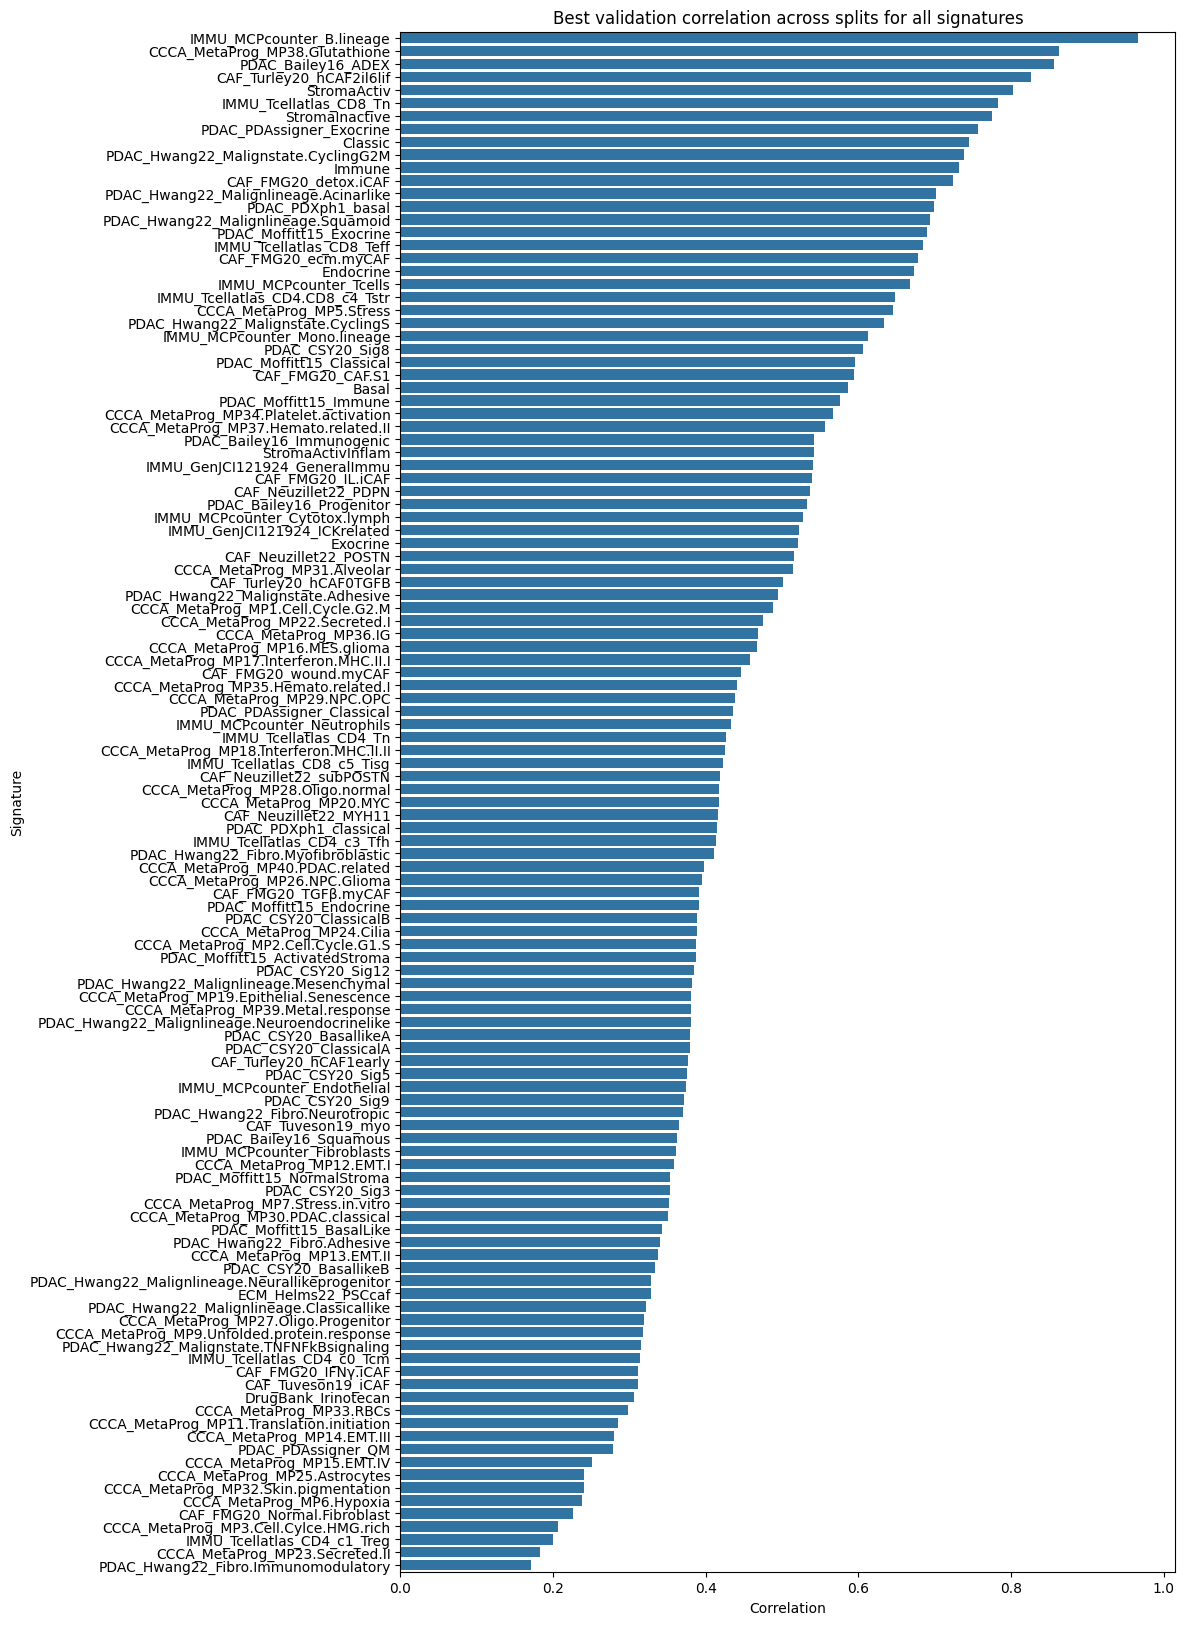

In [10]:
all_sign = recap_df.signature.values
all_sign = list(set(all_sign).union(set(["Classic", "StromaActiv", "Basal", "StromaInactive"])))
all_sign = recap_df[recap_df.signature.isin(all_sign)]

res = all_sign[["signature", "model_path"]]
res_dict = res.set_index("signature").T.to_dict("list")
for k, v in res_dict.items():
    res_dict[k] = v[0].as_posix()
print(f"Keeping {len(res_dict)} models")
np.save(r"C:\Users\inserm\Documents\histo_sign\dataset\all_model_path.npy", res_dict)
plt.figure(figsize=(10, 20))
sns.barplot(data=all_sign, x="best_corr_val", y="signature")
plt.title("Best validation correlation across splits for all signatures")
plt.xlabel("Correlation")
plt.ylabel("Signature")
plt.show()